In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def print_in_color(txt_msg,fore_tupple= (0,255,255) ,back_tupple=(0,0,0)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m', end='') # returns default print color to back to black

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

# fpath=r'/content/drive/MyDrive/cifake/cifake/train/real/0001.jpg'
# img=cv2.imread(fpath)
# print('Image shape is ', img.shape)

Mounted at /content/drive


In [31]:
limiter = 2500
test_dir=r'/content/drive/MyDrive/cifake/cifake/test'
train_dir=r'/content/drive/MyDrive/cifake/cifake/train'
classes=sorted(os.listdir(train_dir))
print('there are ', len(classes), ' classes ', classes[0], ' and ', classes[1])
dir_list=[train_dir, test_dir]
names=['train', 'test']
zip_list=zip(names, dir_list)
for name, dir in zip_list:
    filepaths=[]
    labels=[]
    class_list=sorted(os.listdir(dir))
    for klass in class_list:
        classpath=os.path.join(dir, klass)
        flist=sorted(os.listdir(classpath))
        if name == 'train':
            flist=np.random.choice(flist, limiter, replace=False) # randomly select limiter number of files from train_dir for each class
        else : flist=np.random.choice(flist, 1000, replace=False) 
        desc=f'{name}-{klass}'
        for f in tqdm(flist, ncols=100, colour='blue', unit='files', desc=desc):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
        
 
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if name == 'train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
        train_df, valid_df=train_test_split(train_df, test_size=.2, shuffle=True, random_state=123, stratify=train_df['labels'])
    else:  
        test_df=pd.concat([Fseries, Lseries], axis=1)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 

there are  2  classes  fake  and  real


test-real: 100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 557086.47files/s]

train_df length:  4000   test_df length:  2000   valid_df length:  1000


In [32]:
gen=ImageDataGenerator()
# I will be using an EfficientNet model which requires a minimum image size of 32 X 32
img_size=(32,32)
bs=100 # set the batch size
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=bs)
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
labels=test_gen.labels

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [33]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [34]:
img_shape=(img_size[0], img_size[1], 3)
base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(2, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 

In [35]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, batches, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1        
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches
    
    def on_train_begin(self, logs=None): # this runs on the beginning of training 
        msg1 =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
   
    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}- accuracy=  {3:5.3f} - loss: {4:8.5f}          '.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds') 
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100            
        else:
            pimprov=0.0             
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1 
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)         
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased                     
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'                 
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration) 
                print_in_color(msg, (255,255,0))                
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights                 
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.header=True
                    self.ask_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg) # cyan foreground
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg) # cyan foreground
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg) # cyan foreground
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg) # cyan foreground

In [37]:
ask_epoch= 10 # initially train for 10 epochs   
batches=int(len(train_df)/bs)
# instantiate the custom callback
epochs=100 # max epochs to run
ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch, batches=batches) # instantiate the custom callback
callbacks=[ask] 
# train the model- don't worry aboutthe warning message your model will train correctly
history=model.fit(x=train_gen,   epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training
 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
   1    0.8345    98.35   0.9473    89.30       0.00      0.001000    0.001000     5.21      
   2    0.7146    98.70   0.8413    89.40       11.19     0.001000    0.001000     5.40      
   3    0.6119    99.02   0.7530    89.60       10.50     0.001000    0.001000     5.12      
   4    0.5289    98.98   0.6815    89.70       9.49      0.001000    0.001000     5.36      
   5    0.4630    98.75   0.6127    89.80       10.09     0.001000    0.001000     5.17      
   6    0.4054    98.98   0.5667    90.70       7.52      0.001000    0.001000     5.06      
   7    0.3478    99.42   0

In [38]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

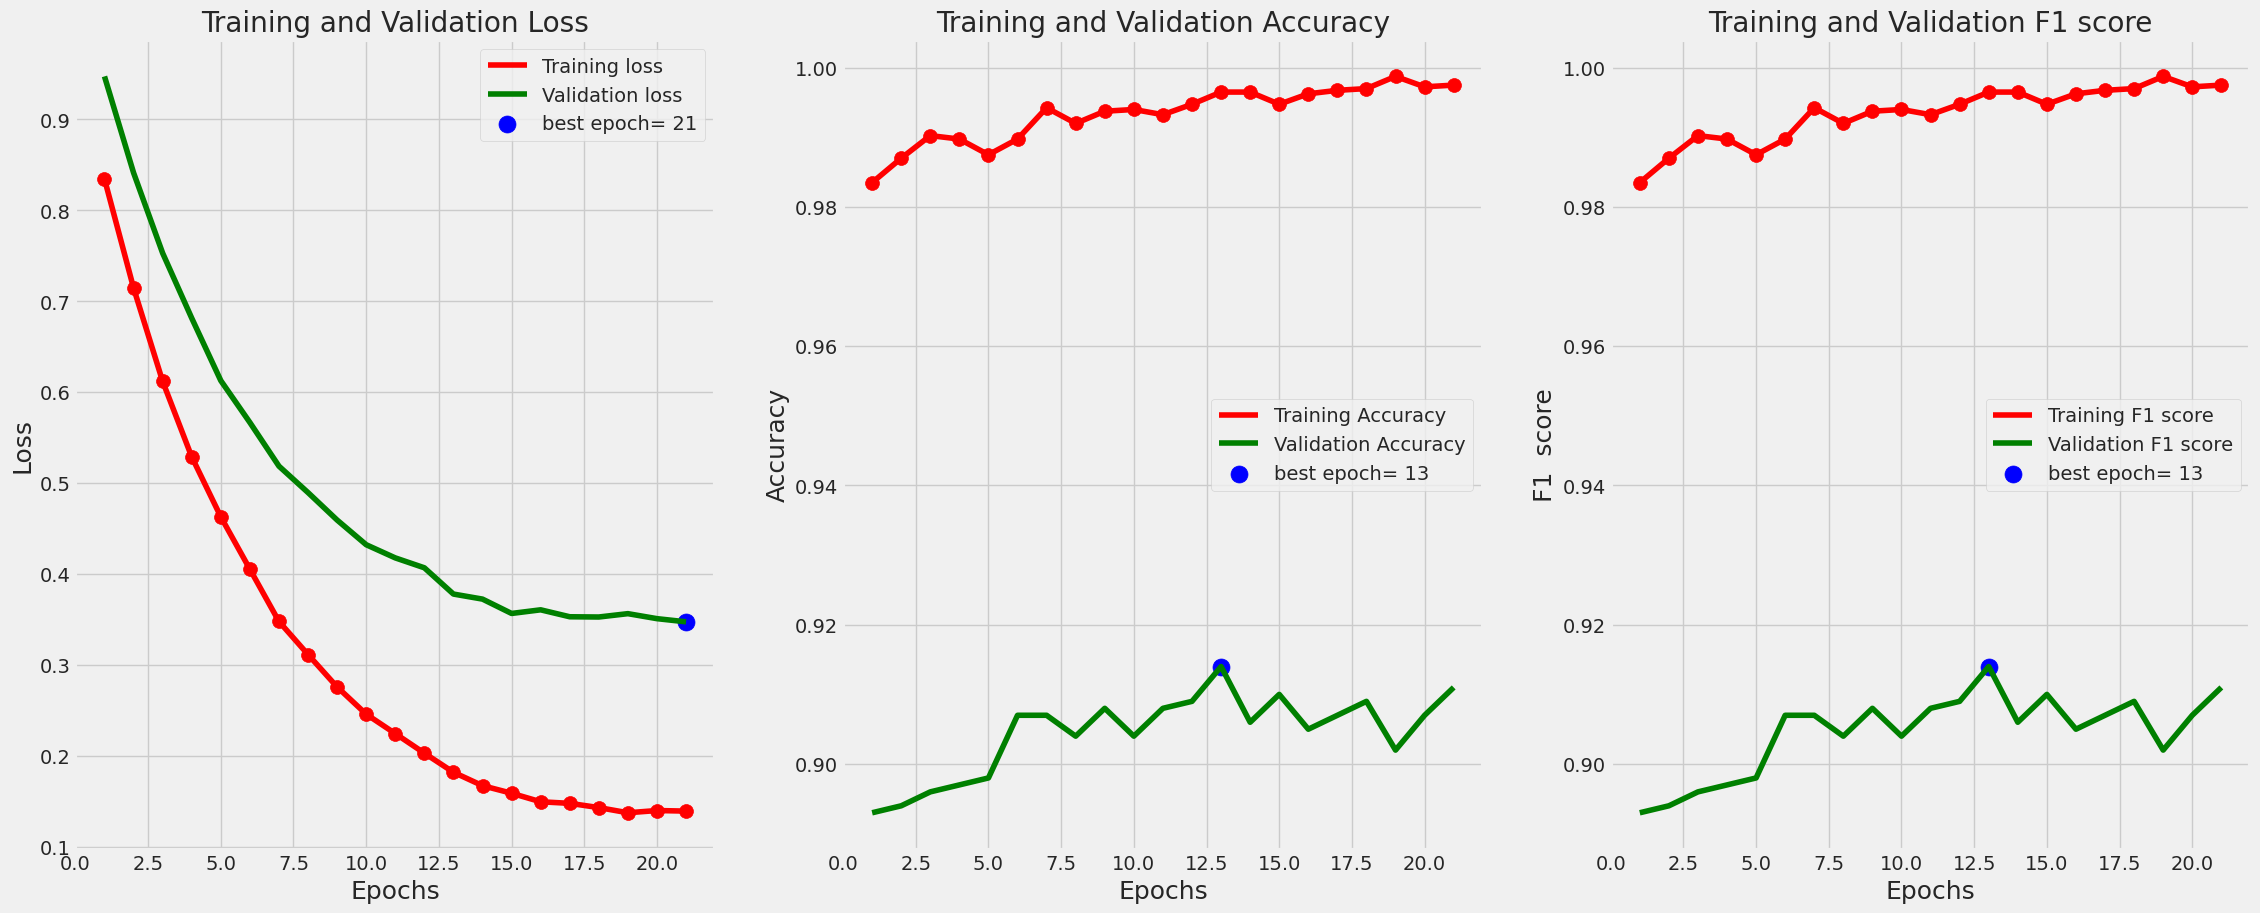

In [39]:
tr_plot(history) # plot the training data

In [40]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

20/20 [==============================] - 895s 47s/step
There were 154 errors in 2000 tests for an accuracy of  92.30 and an F1 score of  92.30


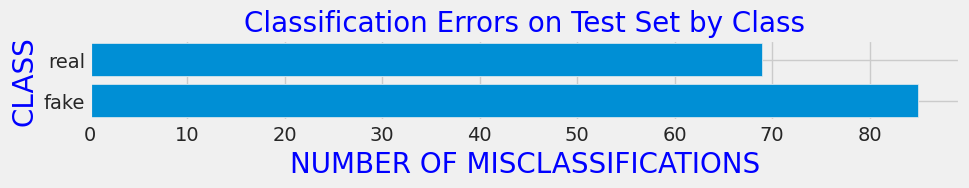

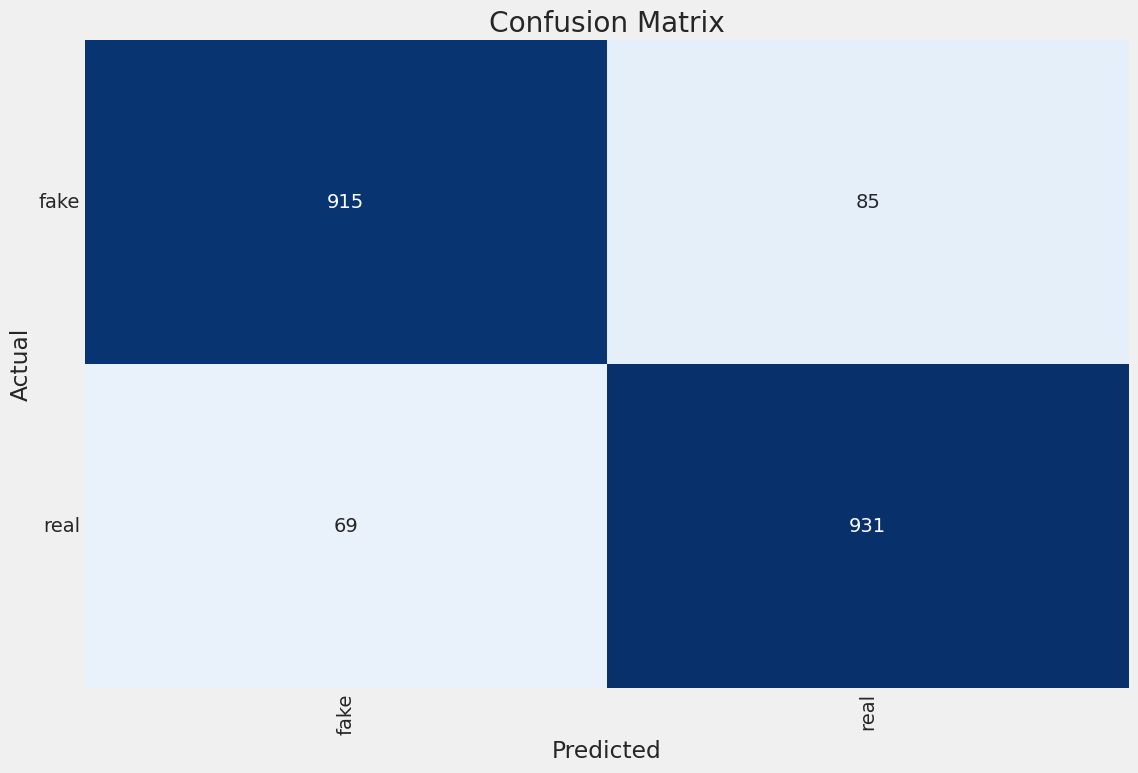

Classification Report:
----------------------
               precision    recall  f1-score   support

        fake     0.9299    0.9150    0.9224      1000
        real     0.9163    0.9310    0.9236      1000

    accuracy                         0.9230      2000
   macro avg     0.9231    0.9230    0.9230      2000
weighted avg     0.9231    0.9230    0.9230      2000



In [41]:
f1score=predictor(model,test_gen)